In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the dataset
file_path = '../Tapes/UoB_Set01_2025-01-02tapes.csv'  # Update this to the path of your CSV file
data = pd.read_csv(file_path, header=None, names=['seconds', 'transaction_price', 'number_of_transactions'])

# Convert seconds to a timedelta and then to a datetime starting from a reference point
data['timestamp'] = pd.to_timedelta(data['seconds'], unit='s') + pd.Timestamp('2025-01-02 00:00')
data.set_index(keys='timestamp', inplace=True)

# Resample the transaction prices to get mean values per second
resampled_data = data['transaction_price'].resample('1S').mean()

# Forward-fill the missing values
resampled_data_ffill = resampled_data.fillna(method='ffill').dropna()

split_point = int(len(resampled_data_ffill) * 0.75)
train_data = resampled_data_ffill[:split_point].asfreq('S')
test_data = resampled_data_ffill[split_point:].asfreq('S')

/var/folders/1f/gqtm7m2d6mq4y_35lmr6nxrc0000gn/T/ipykernel_38566/3889995158.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_data_ffill = resampled_data.fillna(method='ffill').dropna()


In [8]:
a = []
print(a)
a[0:] = [1,2,3,4,5,6,7,8,9,10]
print(a)

print(resampled_data_ffill)


[]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
timestamp
2025-01-02 00:00:10    267.0
2025-01-02 00:00:11    268.0
2025-01-02 00:00:12    270.0
2025-01-02 00:00:13    267.0
2025-01-02 00:00:14    267.0
                       ...  
2025-01-02 08:29:55    285.0
2025-01-02 08:29:56    286.0
2025-01-02 08:29:57    286.0
2025-01-02 08:29:58    287.5
2025-01-02 08:29:59    290.0
Freq: S, Name: transaction_price, Length: 30590, dtype: float64


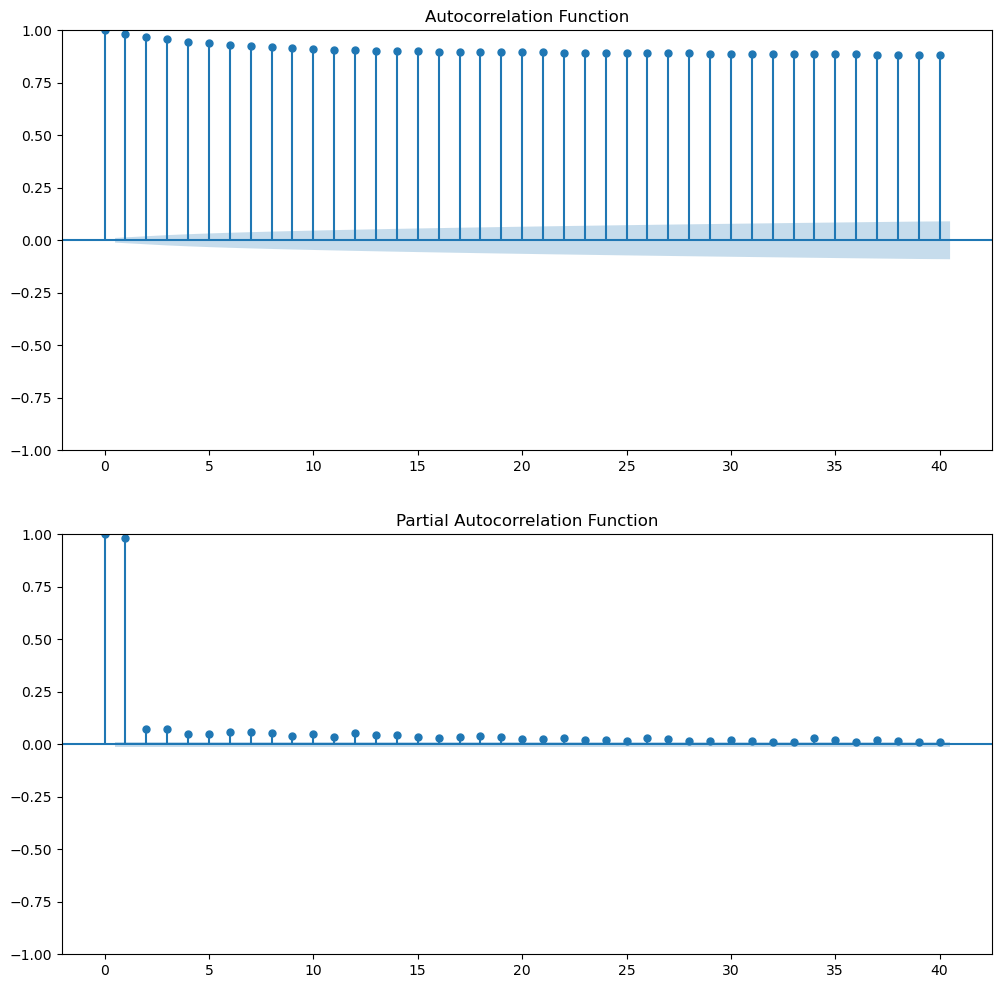

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot the Autocorrelation Function (ACF)
plot_acf(resampled_data_ffill, lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function')

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(resampled_data_ffill, lags=40, ax=ax2, method='ywm')
ax2.set_title('Partial Autocorrelation Function')

plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller

print(resampled_data_ffill)
# Perform Augmented Dickey-Fuller test
adf_test = adfuller(resampled_data_ffill)

# Create a DataFrame to display test results
adf_results = pd.DataFrame({'ADF Statistic': [adf_test[0]], 'p-value': [adf_test[1]],
                            'Critical Values': [adf_test[4]]})
adf_results


timestamp
2025-01-02 00:00:10    267.0
2025-01-02 00:00:11    268.0
2025-01-02 00:00:12    270.0
2025-01-02 00:00:13    267.0
2025-01-02 00:00:14    267.0
                       ...  
2025-01-02 08:29:55    285.0
2025-01-02 08:29:56    286.0
2025-01-02 08:29:57    286.0
2025-01-02 08:29:58    287.5
2025-01-02 08:29:59    290.0
Freq: S, Name: transaction_price, Length: 30590, dtype: float64


,ADF Statistic,p-value,Critical Values
0,-3.851023,0.002426,"{'1%': -3.430564154488211, '5%': -2.8616346505..."


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
12

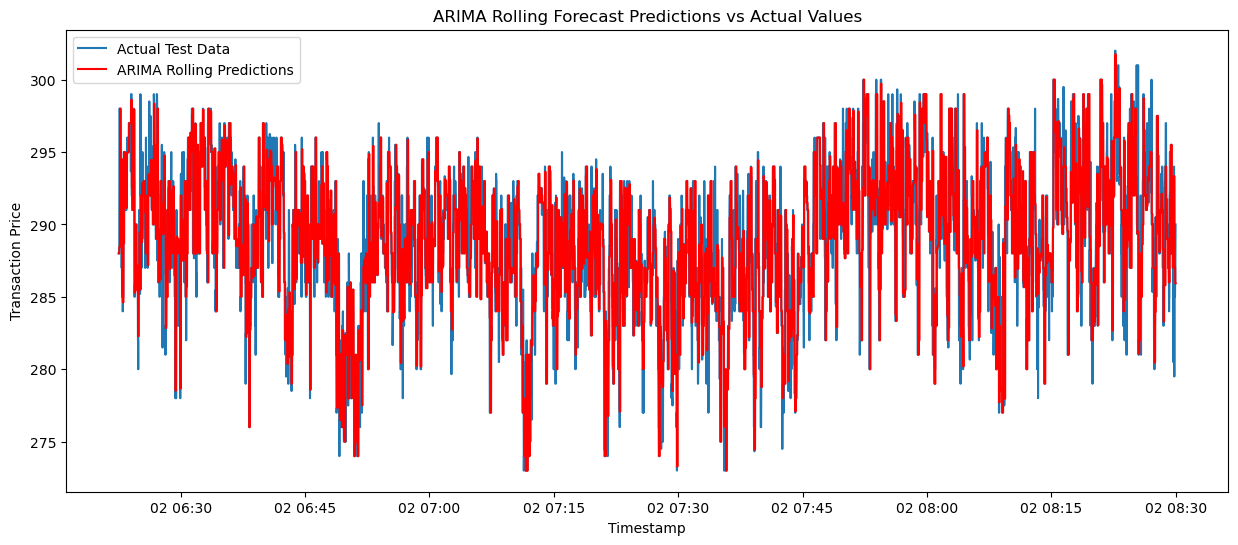

In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming train_data and test_data are pandas Series with datetime indices

# Set the frequency of the time series data
train_data = train_data.asfreq('S')
test_data = test_data.asfreq('S')

# Ensure the indices are monotonically increasing
train_data = train_data.sort_index()
test_data = test_data.sort_index()

# Check for duplicates and remove them if necessary
train_data = train_data[~train_data.index.duplicated(keep='first')]

# Define the frequency of model updates
update_frequency = 5  # Retrain the model every 5 steps

# Initialize the history with the training data
history = train_data.copy()

# Prepare a list to store predictions
predictions = []

# Preallocate the space for performance optimization
predictions = [None] * len(test_data)

# Start rolling forecast with updates every 5 steps
for t in range(0, len(test_data), update_frequency):
    # Fit the ARIMA model on the current history
    model = ARIMA(history, order=(1,2,1))
    model_fit = model.fit()
    
    # Make predictions for the next 5 steps
    next_steps_predictions = model_fit.forecast(steps=update_frequency)
    
    # Store the predictions
    if t + update_frequency < len(test_data):
        predictions[t:t+update_frequency] = next_steps_predictions
    else:
        predictions[t:] = next_steps_predictions[:len(test_data)-t]
    
    # Update the history with the new observations
    if t + update_frequency < len(test_data):
        new_history = test_data[t:t+update_frequency]
        history = pd.concat([history, new_history])
    print(t)

print(len(predictions))
print(len(test_data.index))
# Convert predictions to a Series for easy plotting
predictions_series = pd.Series(predictions, index=test_data.index)

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(predictions_series.index, predictions_series, label='ARIMA Rolling Predictions', color='red')
plt.title('ARIMA Rolling Forecast Predictions vs Actual Values')
plt.xlabel('Timestamp')
plt.ylabel('Transaction Price')
plt.legend()
plt.show()



In [20]:
# calculate RMSE and save the prediction into a csv
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions_series))
print(f"Root Mean Squared Error (RMSE) of Predictions: {rmse}")

# Save the predictions to a CSV file
predictions_series.to_csv('arima_121_predictions.csv', header=['transaction_price'])

Root Mean Squared Error (RMSE) of Predictions: 3.627510591190856


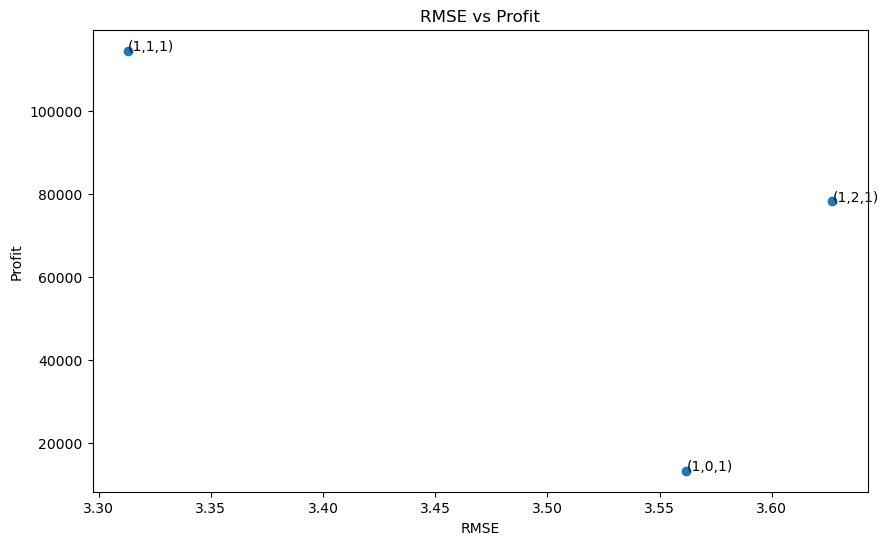

In [23]:
# plot a scatter plot where x is the rmse, and y is the profit, each point represents a different model order
rmse = [3.313, 3.562, 3.627]
profit = [114524, 13315, 78214]
orders = ['(1,1,1)', '(1,0,1)', '(1,2,1)']

# each point represents a different model order
plt.figure(figsize=(10, 6))
plt.scatter(rmse, profit)
for i, txt in enumerate(['(1,1,1)', '(1,0,1)', '(1,2,1)']):
    plt.annotate(txt, (rmse[i], profit[i]))
plt.xlabel('RMSE')
plt.ylabel('Profit')
plt.title('RMSE vs Profit')
plt.show()

In [ ]:
rmse = [3.313, 3.562, 3.627]
profit = [114524, 13315, 78214]

# each point represents a different model order
plt.figure(figsize=(10, 6))
plt.scatter(rmse, profit)
for i, txt in enumerate(['(1,1,1)', '(1,0,1)', '(1,2,1)']):
    plt.annotate(txt, (rmse[i], profit[i]))
plt.xlabel('RMSE')
plt.ylabel('Profit')
plt.title('RMSE vs Profit')
plt.show()

Below code are still in progress, and it's aimed to try out with different parameters i.e. order of the ARIMA model to see any performance difference.

In [36]:
from statsmodels.tsa.arima.model import ARIMA

# Initial model: ARIMA(1,1,1)
model = ARIMA(train_data, order=(5, 1, 1))
model_fit = model.fit()


/Users/casperwang/.conda/envs/classifier/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/casperwang/.conda/envs/classifier/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [37]:
predictions = model_fit.forecast(steps=len(test_data))
print(predictions[:50])

2025-01-02 08:24:54    292.029254
2025-01-02 08:24:55    292.061641
2025-01-02 08:24:56    292.097570
2025-01-02 08:24:57    292.128428
2025-01-02 08:24:58    292.154898
2025-01-02 08:24:59    292.177584
2025-01-02 08:25:00    292.196966
2025-01-02 08:25:01    292.213491
2025-01-02 08:25:02    292.227579
2025-01-02 08:25:03    292.239590
2025-01-02 08:25:04    292.249830
2025-01-02 08:25:05    292.258558
2025-01-02 08:25:06    292.265999
2025-01-02 08:25:07    292.272343
2025-01-02 08:25:08    292.277750
2025-01-02 08:25:09    292.282360
2025-01-02 08:25:10    292.286290
2025-01-02 08:25:11    292.289640
2025-01-02 08:25:12    292.292496
2025-01-02 08:25:13    292.294930
2025-01-02 08:25:14    292.297006
2025-01-02 08:25:15    292.298775
2025-01-02 08:25:16    292.300283
2025-01-02 08:25:17    292.301569
2025-01-02 08:25:18    292.302665
2025-01-02 08:25:19    292.303599
2025-01-02 08:25:20    292.304395
2025-01-02 08:25:21    292.305074
2025-01-02 08:25:22    292.305653
2025-01-02 08:

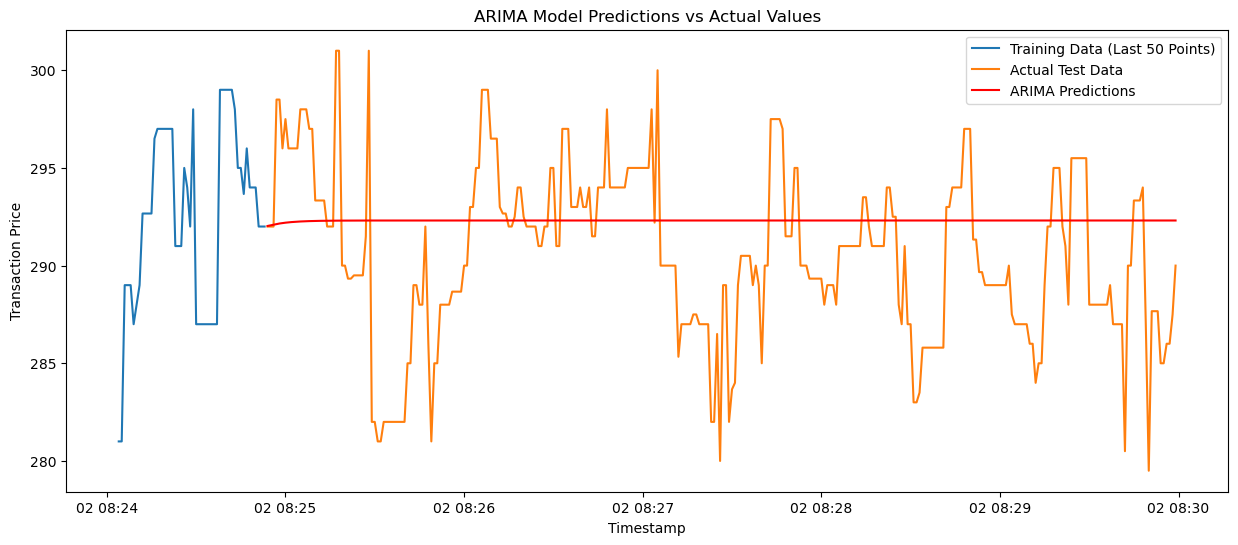

Root Mean Squared Error (RMSE) of Predictions: 4.703228213894379


In [38]:


plt.figure(figsize=(15, 6))
plt.plot(train_data.index[-50:], train_data[-50:], label='Training Data (Last 50 Points)')
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(test_data.index, predictions, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model Predictions vs Actual Values')
plt.xlabel('Timestamp')
plt.ylabel('Transaction Price')
plt.legend()
plt.show()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f"Root Mean Squared Error (RMSE) of Predictions: {rmse}")
